<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/VisualBERT_VQA_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VisualBert
https://huggingface.co/docs/transformers/model_doc/visual_bert

Transformer by huggingface"

page: https://www.libhunt.com/r/transformers

Github: https://github.com/huggingface/transformers

Installation

In [29]:
!pip install -q transformers wget

In [23]:
!git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 106391, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 106391 (delta 8), reused 10 (delta 4), pack-reused 106376
Receiving objects: 100% (106391/106391), 98.57 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (78617/78617), done.


In [27]:
%cd transformers/examples/research_projects/visual_bert

/content/transformers/examples/research_projects/visual_bert


In [ ]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast

# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
#URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"

# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL);
attrids = utils.get_data(ATTR_URL);
vqa_answers = utils.get_data(VQA_URL);

# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned");
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg);
image_preprocess = Preprocess(frcnn_cfg);
images, sizes, scales_yx = image_preprocess(URL);
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
);



bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased");
visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");

In [36]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
]

# Very important that the boxes are normalized
# normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

for test_question in test_questions_for_url2:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print("Question:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])


Question: ['Where is the cat?']
prediction from VisualBert VQA: outside
Question: ['What is near the disk?']
prediction from VisualBert VQA: nothing
Question: ['What is the color of the table?']
prediction from VisualBert VQA: brown
Question: ['What is the color of the cat?']
prediction from VisualBert VQA: gray
Question: ['What is the shape of the monitor?']
prediction from VisualBert VQA: square


# Ablation

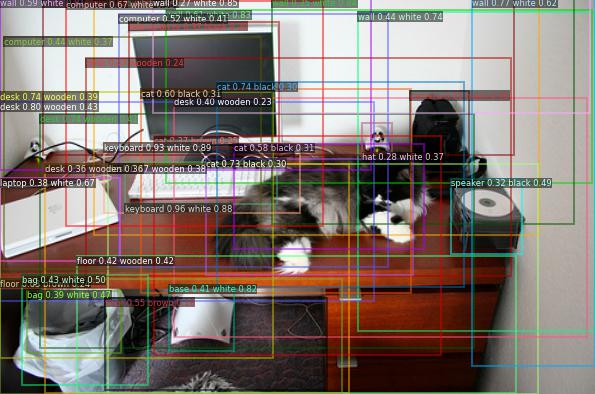

In [40]:
# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

